# Five Stars - NLP

Andy Tan

The aim of this project is to use topic modeling of yelp reviews to predict 5-star restaurant ratings.

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import umap

import re
import string

import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

## Data Preparation
Data was obtained from the Yelp Open Dataset. The subset loaded here includes Toronto restaurant reviews. Please see "five_stars_data.ipynb" notebook for additional code on data collection.

In [42]:
df = pd.read_pickle('yelp_rest_toronto.pkl')

In [43]:
df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432479 entries, 0 to 432478
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   432479 non-null  object 
 1   postal_code   432479 non-null  object 
 2   review_count  432479 non-null  int64  
 3   is_open       432479 non-null  int64  
 4   stars_bus     432479 non-null  float64
 5   stars_user    432479 non-null  float64
 6   text          432479 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 26.4+ MB
        review_count        is_open      stars_bus     stars_user
count  432479.000000  432479.000000  432479.000000  432479.000000
mean      217.412344       0.782299       3.624514       3.628794
std       315.928306       0.412683       0.567349       1.281967
min         3.000000       0.000000       1.000000       1.000000
25%        51.000000       1.000000       3.500000       3.000000
50%       119.000000       1.000000

### Initial data cleaning

In [44]:
#Filter out closed restaurants
#Filter out reviews with non-ASCII characters
df = df[df.is_open == 1].loc[df['text'].str.contains(r'[^\x00-\x7F]+') == False]

In [45]:
#Create feature labeling if a review is five stars
df['five_stars'] = np.where(df['stars_user'] == 5, 1, 0)

### Sampling
The full dataset is too large to handle in the upcoming analysis. We will take a random sample of 60,000 reviews from the dataset. We are also sampling a random restaurant and loading all of the reviews for that restaurant into a dataframe to be used for later analysis.

In [47]:
#All reviews for one random 4-star restaurant
df_case1 = df.loc[df['business_id'].isin(pd.Series(df[(df['stars_bus']==4.5) & (df['review_count']>10)]['business_id'].unique()).sample(1, random_state=6))]
df_case1

,business_id,postal_code,review_count,is_open,stars_bus,stars_user,text,five_stars
225692,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,4.0,I read about this place in a blog and I am so ...,0
225693,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,5.0,Been there a couple of times and empanadas are...,1
225694,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,4.0,Check out this new Latin American cafe and gro...,0
225695,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,5.0,The best iced coffee I've ever had in Toronto!...,1
225696,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,5.0,This place just opened right in my neighbourho...,1
225698,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,3.0,The interior is a small little grocery store w...,0
225699,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,5.0,Love love love this place! Only place in the c...,1
225700,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,4.0,Happened upon this cafe when walking along wha...,0
225701,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,5.0,"Beautiful cafe, I am Latin and is the first ti...",1
225702,AoItX6upESFG_EowRa05eg,M6G 1K8,33,1,4.5,4.0,Great little spot. Run by real people. Recomme...,0


In [7]:
#Generating random sample of 60,000 reviews
df = df.sample(60000, random_state=12)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 247110 to 97166
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   60000 non-null  object 
 1   postal_code   60000 non-null  object 
 2   review_count  60000 non-null  int64  
 3   is_open       60000 non-null  int64  
 4   stars_bus     60000 non-null  float64
 5   stars_user    60000 non-null  float64
 6   text          60000 non-null  object 
 7   five_stars    60000 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 4.1+ MB


### EDA

In [8]:
#User rating breakdown. 4 and 5 star reviews are the most common.
df.stars_user.value_counts()

5.0    19165
4.0    19111
3.0    10181
1.0     5788
2.0     5755
Name: stars_user, dtype: int64

Text(0, 0.5, 'Count')

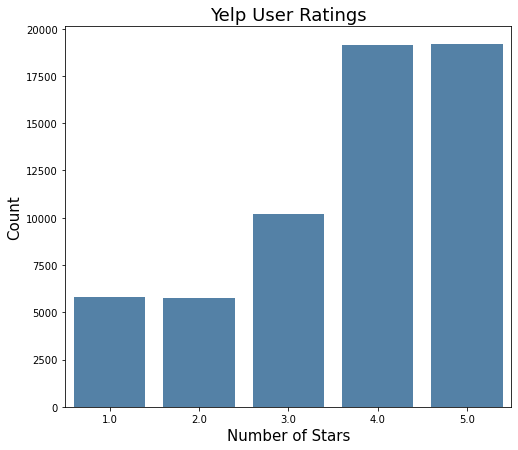

In [9]:
#Plot of user rating distribution
plt.figure(figsize=(8,7))
sns.countplot(df.stars_user, color='steelblue')
plt.title('Yelp User Ratings', fontsize=18)
plt.xlabel('Number of Stars', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [10]:
#Class balance for later classification
df.five_stars.value_counts()

print("<= 4 stars: {} ({:5.2f}%)".format(df['five_stars'].value_counts()[0], 100*df['five_stars'].value_counts()[0]/df['five_stars'].count()))
print("5 stars: {} ({:5.2f}%)".format(df['five_stars'].value_counts()[1], 100*df['five_stars'].value_counts()[1]/df['five_stars'].count()))

<= 4 stars: 40835 (68.06%)
5 stars: 19165 (31.94%)


In [11]:
#Number of unique restaurants in sample
df.business_id.nunique()

4838

## NLP

### Preprocess the text data

In [12]:
stemmer = SnowballStemmer(language='english')

In [13]:
def text_preprocessor(text):
    '''
    Function for cleaning text strings. Reduces words to word stems.
    
    args:
        text: string of review text
        
    output:
        text: cleaned text    
    '''
    #match alphanumeric characters
    text = re.sub('\w*\d\w*', ' ', text)
    
    #remove punctuation, and change to lower case
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
    
    #get word stems
    stem_words=[]
    for word in word_tokenize(text):
            stem_words.append(stemmer.stem(word))
        
    text = ' '.join(stem_words)
    
    return text

In [14]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    '''
    Function for printing topics. Also saves topics in dictionary.
    
    args:
        model: topic modeler
        feature_names: word list
        no_top_words: number of words to save per topic
        topic_names: names to label topics
        
    output:
        topic_dict: dictionary of topics and associated words/phrases
    '''
    topic_dict = {}
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            key = ix
            print("\nTopic ", key)
        else:
            key = topic_names[ix]
            print("\nTopic: '",key,"'")
        words = ", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        topic_dict[key] = words
        print(words)
        
    return topic_dict

In [15]:
#Applying preprocessing function to corpus
df['text'] = df['text'].map(text_preprocessor)

In [16]:
df.head()

,business_id,postal_code,review_count,is_open,stars_bus,stars_user,text,five_stars
247110,XCUXCTHvY8QVR4xU0DF__w,M4M 1Y2,84,1,3.5,3.0,incred cramp entre way you have to wait in to ...,0
181990,j0aiaJkrU-5VgbCsdx-txg,M1T 2M5,318,1,4.5,3.0,i got the jerk chicken poutin which was and en...,0
412120,Yv4P4qUwd7F-qQ4Y4eD1JQ,M2N 5N2,284,1,3.5,5.0,probabl one of my favourit place to come for d...,1
199140,Kdt5XrqARBMIH694fgnyuA,M6R 1B2,46,1,3.5,1.0,cute place sure but do not do not do not come ...,0
242605,mDA6_CDxdyQ-_qO5RHloow,M5J 2T3,382,1,3.0,4.0,i use to go march a lot in the earli so i know...,0


### Prepare data for modeling

In [17]:
#Splitting data into test and train sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=12)

In [18]:
#Creating subset containing only 5-star reviews. This will be used for later analysis
df_five = df_train[df_train.five_stars == 1]

In [19]:
#Separating test/train sets into target and features
y_train = df_train.five_stars
X_train = df_train.text
y_test = df_test.five_stars
X_test = df_test.text

### Vectorize text documents

In [20]:
#Generating list of stop words
stop_words = nltk.corpus.stopwords.words('english')

food = wn.synset('food.n.02')
food_words = set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()])
food_words = list(f.strip('_').replace('_',' ').lower() for f in food_words)

more_stop_words = ['cream', 'chicken', 'burger', 'pizza', 'milk', 'pickl',
                    'kimchi', 'sushi', 'ramen', 'thai', 'dim', 'tea', 'banh', 'khao',
                   'indian', 'korean', 'chines', 'noodl', 'tom yum',
                   'fast food', 'food court', 'toronto', 'place',
                  'back', 'recommend', 'better', 'best', 'noth', 'favourit', 'favorit', 'star',
                   'disappoint', 'love', 'definit']

stop_words.extend(food_words)
stop_words.extend(more_stop_words)

Both CountVectorizer and TF-IDF were tried for vectorization. TF-IDF appeared to lead to more interpretable topics and was used in final model.

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(2,3), stop_words=stop_words, min_df=10, max_df=0.8)
#vectorizer = CountVectorizer(ngram_range=(2,3), stop_words=stop_words, min_df=10, max_df=0.9, binary=False)

doc_word_matrix = vectorizer.fit_transform(X_train)
X_test_dwm = vectorizer.transform(X_test)

#df_dwm = pd.DataFrame(doc_word_matrix.toarray(), columns=vectorizer.get_feature_names())

/home/andy/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acorn', 'agneau', 'alaska', 'alaskan', 'albert', 'alfalfa', 'alfredo', 'alimentary', 'alligator', 'almond', 'american', 'anadama', 'angel', 'anise', 'applesauce', 'armerican', 'ash', 'atlantic', 'au', 'baked', 'baking', 'ball', 'bamboo', 'bar', 'barbados', 'batter', 'bavarian', 'bay', 'beach', 'bear', 'beauty', 'belgian', 'bell', 'belly', 'beluga', 'berlin', 'bermuda', 'beurre', 'bibb', 'bing', 'birthday', 'bitter', 'bittersweet', 'black', 'blood', 'blue', 'bok', 'bone', 'boston', 'bottom', 'bowtie', 'bramley', 'bran', 'breakfast', 'breast', 'brick', 'broad', 'brook', 'brown', 'brussels', 'buckwheat', 'bullace', 'bullock', 'bully', 'burnet', 'buttercup', 'butterhead', 'buttermilk', 'butternut', 'cajan', 'calabash', 'calf', 'calves', 'canadian', 'candy', 'caramel', 'caraw

## Topic Modeling
Topic modeling was performed with LSA, NMF, and LDA. NMF was chosen for final analysis due to more interpretable topics.

In [22]:
num_topics = 50

nmf = NMF(num_topics, random_state=12)
#lsa = TruncatedSVD(num_topics, random_state=12)
#lda = LatentDirichletAllocation(num_topics, random_state=12)

In [23]:
dtm_nmf = nmf.fit_transform(doc_word_matrix)
#dtm_lsa = lsa.fit_transform(doc_word_matrix)
#dtm_lda = lda.fit_transform(doc_word_matrix)

In [24]:
#lsa.explained_variance_ratio_

### Topic visualization
Visualization was performed with UMAP with colors assigned based on 5-star rating status. On gross visual inspection, there does not appear to be much linear separability

In [25]:
topic_map = umap.UMAP(random_state=12).fit_transform(dtm_nmf)

Text(0.5, 1.0, 'Topic Visualization with UMAP')

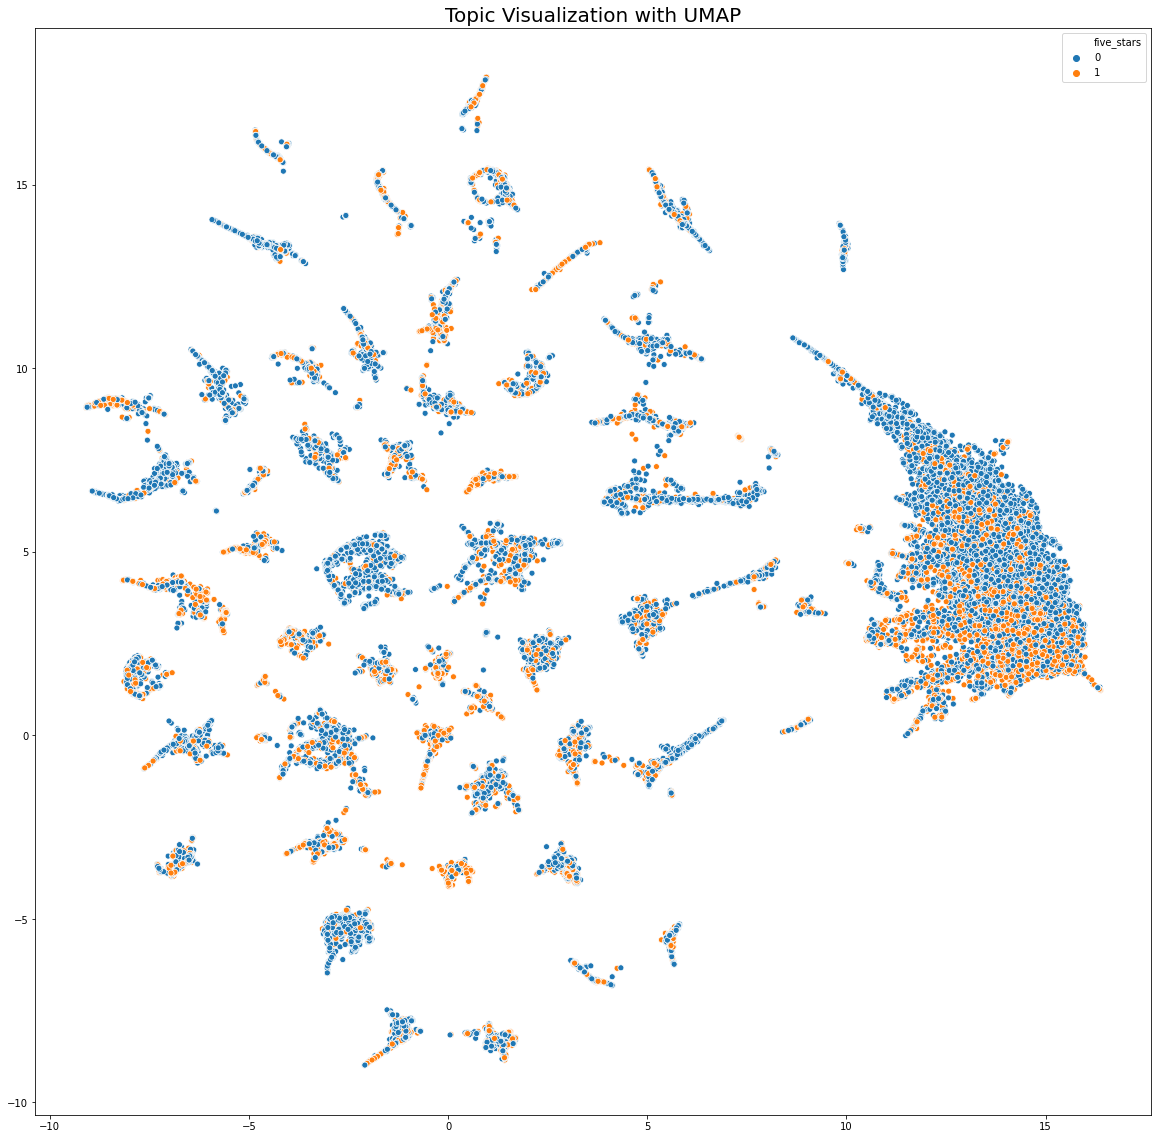

In [26]:
plt.figure(figsize=(20,20))
sns.scatterplot(topic_map[:, 0], topic_map[:, 1], hue=y_train)
plt.title('Topic Visualization with UMAP', fontsize=20)

In [27]:
#Printing topics
topics = display_topics(nmf, vectorizer.get_feature_names(), 10)
#display_topics(lsa, vectorizer.get_feature_names(), 10)
#display_topics(lda, vectorizer.get_feature_names(), 10)


Topic  0
portion size, good portion, good portion size, lunch special, small portion, size great, price portion, portion size great, great portion, price portion size

Topic  1
food great, food great servic, great food great, great price, food great price, good food great, food great atmospher, delici food great, amaz food great, servic food great

Topic  2
veri good, also veri, also veri good, food veri good, veri good food, servic veri good, veri good servic, good veri, veri good price, tast veri good

Topic  3
food good, good price, food good servic, good food good, food good price, great food good, food good portion, servic food good, good atmospher, time food good

Topic  4
great food, great food great, servic great food, great food servic, great food good, staff great food, staff great, great food amaz, great food awesom, atmospher great food

Topic  5
realli good, food realli, food realli good, also realli, realli good food, servic realli, also realli good, realli nice, servic 

## Classification Modeling
The topics were used as features for a binary classification model with target being 5-star rating. The main aim of classification modeling is to use feature importance to determine which topics are predictive of 5-stars.

In [28]:
#Generating topic mastrix for test features
X_test_dtm = nmf.transform(X_test_dwm)

Logistic Regression hyperparameters tuned with GridSearchCV

c_range = 10**np.linspace(-3,3,7)
param_grid = dict(C=c_range, solver=['saga'], max_iter=[10000])

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid.fit(X_tr_std, y_train)

print(f'Best Logistic Regression score: {grid.best_score_}')
print(f'Best Logistic Regression parameters: {grid.best_params_}')

In [29]:
lr = LogisticRegression(C=100, solver='saga', max_iter=10000)

In [30]:
lr.fit(dtm_nmf, y_train)
y_pred = lr.predict(X_test_dtm)

In [31]:
#Printing metric scores
print("The score for Logistic Regression is")
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("F1: {}".format(f1_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred)))
print("Recall: {}".format(recall_score(y_test, y_pred)))

The score for Logistic Regression is
Accuracy: 0.7010833333333333
F1: 0.2867369258301849
Precision: 0.6275021758050479
Recall: 0.18582474226804124


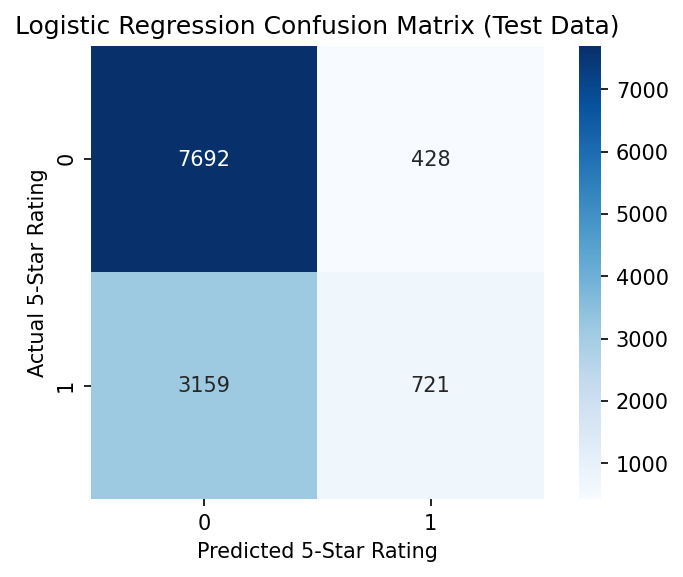

In [32]:
# Confusion matrix for test set
lr_confusion = confusion_matrix(y_test,y_pred)
plt.figure(dpi=150)
sns.heatmap(lr_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted 5-Star Rating')
plt.ylabel('Actual 5-Star Rating')
plt.title('Logistic Regression Confusion Matrix (Test Data)');

### Feature Importance
Beta coefficients from the logistic regression model were used to determine feature importance. 

In [33]:
pd.set_option('display.max_colwidth', None)

df_lr_feats = pd.DataFrame.from_dict({'Topic':list(topics.keys()),
                                      'Coef': lr.coef_[0],
                                      'Topic_Words': list(topics.values())})

df_lr_feats['Color'] = df_lr_feats['Coef'].apply(lambda coef: 'red' 
                                                          if coef < 0 else sns.xkcd_rgb["medium green"])

df_lr_feats = df_lr_feats.sort_values('Coef', ascending = True).reset_index(drop = True)

df_lr_feats.head(10).append(df_lr_feats.tail(10))


,Topic,Coef,Topic_Words,Color
0,27,-96.832508,"even though, wait minut, long time, wait time, take order, seem like, order food, long wait, right away, told us",red
1,7,-28.455626,"pretti good, food pretti, food pretti good, servic pretti, servic pretti good, pretti good food, tast pretti, tast pretti good, pretti good servic, also pretti",red
2,10,-26.764140,"tast like, sauc tast, sauc tast like, food tast, food tast like, realli tast, like water, tast like water, realli tast like, good tast",red
3,0,-25.459641,"portion size, good portion, good portion size, lunch special, small portion, size great, price portion, portion size great, great portion, price portion size",red
4,3,-18.513772,"food good, good price, food good servic, good food good, food good price, great food good, food good portion, servic food good, good atmospher, time food good",red
5,47,-11.923827,"look like, look like much, like much, chees look, menu look, look like someon, coffe shop, like someon, tast good, littl bit",red
6,24,-11.118844,"servic good, servic good food, good servic good, great servic good, custom servic good, servic good price, good price, good atmospher, friend servic good, servic good atmospher",red
7,49,-9.762340,"fast food, food court, servic fast, tast good, food tast, fast friend, servic fast food, servic fast friend, food restaur, fast food restaur",red
8,30,-7.562352,"fri rice, deep fri, stir fri, sweet sour, order fri, rice fri, pan fri, hot sour, sour soup, fri dumpl",red
9,29,-7.448703,"would go, go tri, would go tri, food would go, food would, good would go, go way, go sure, good would, would go sure",red


In [34]:
pd.reset_option('display.max_colwidth')

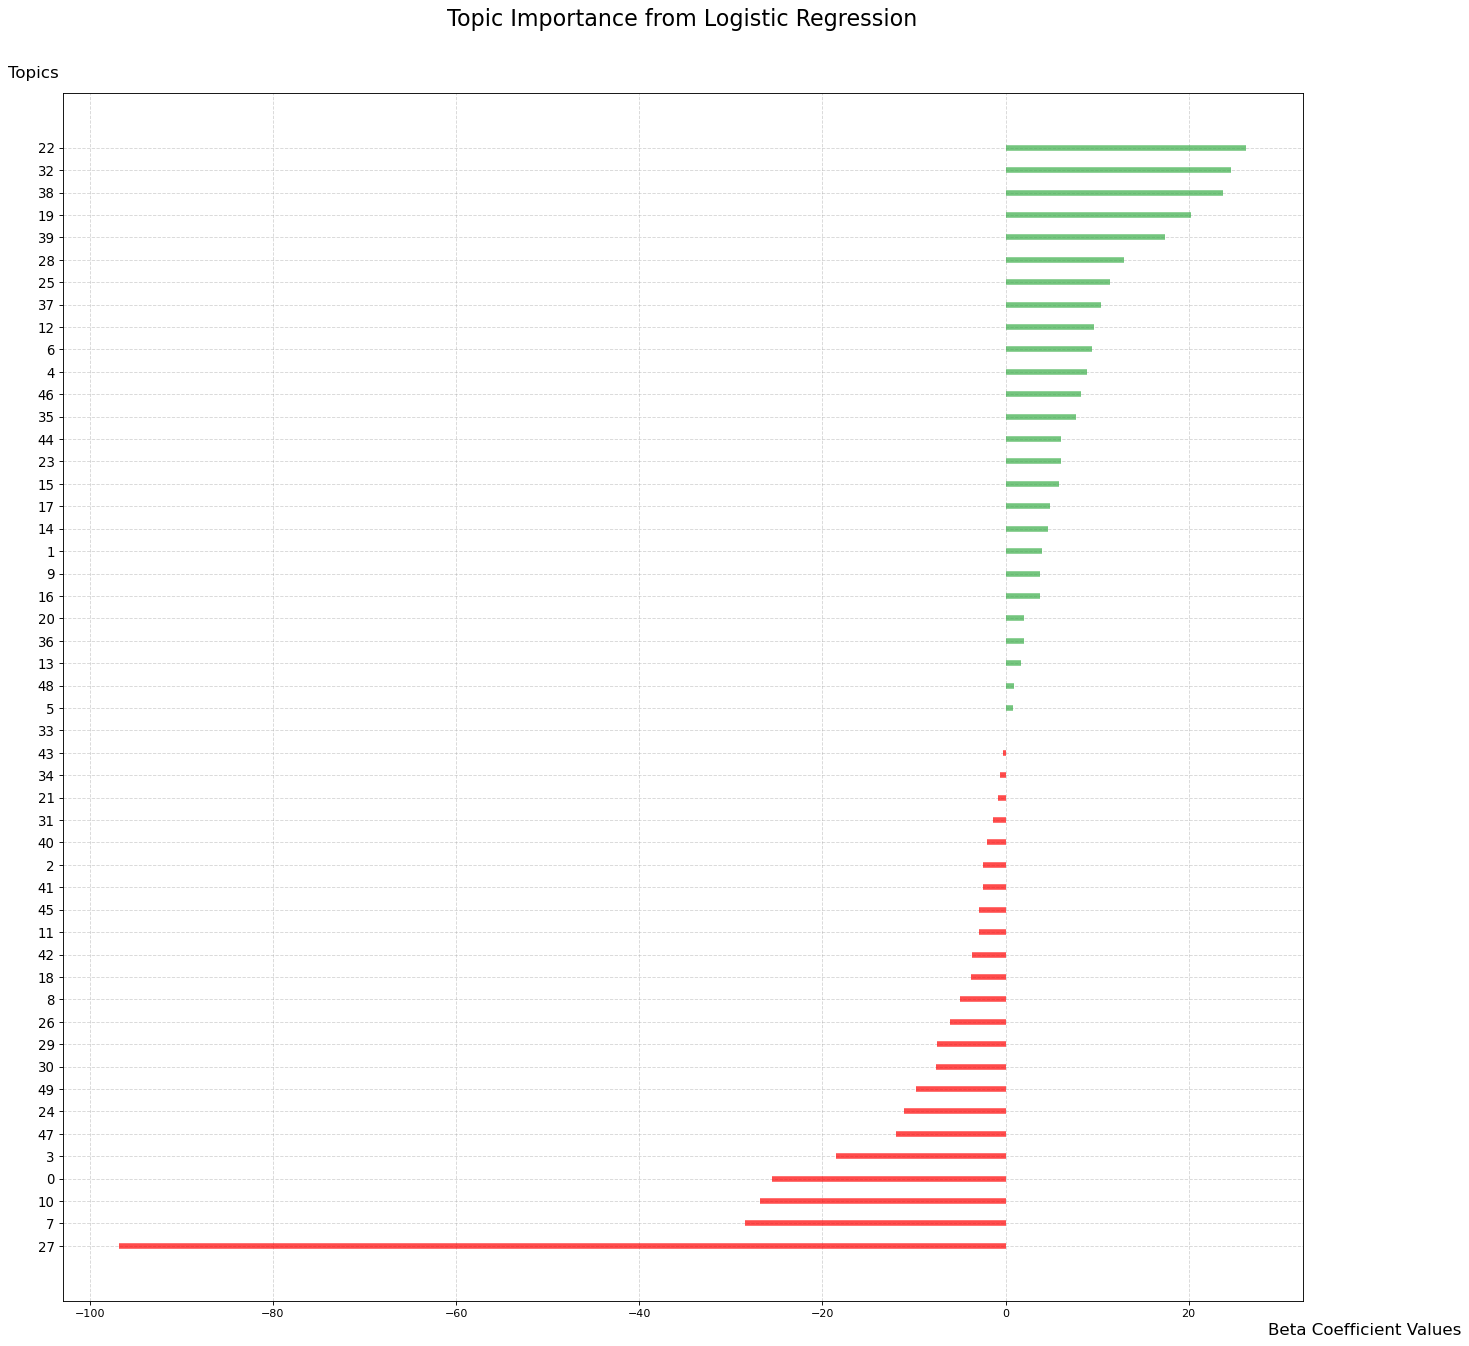

In [35]:
#Plotting feature importance
plt.figure(figsize=(20,20), dpi= 80)
plt.hlines(y = df_lr_feats.index, xmin = 0, xmax = df_lr_feats['Coef'], 
           color=  df_lr_feats['Color'], alpha=0.7, linewidth=5)

plt.xlabel(xlabel = 'Beta Coefficient Values', size = 15, x = 1.05)
plt.ylabel(ylabel = 'Topics', size = 15, rotation = 0, y = 1.01)

plt.yticks(df_lr_feats.index, df_lr_feats['Topic'], fontsize=12)
plt.title('Topic Importance from Logistic Regression', fontsize=20, y = 1.05)
plt.grid(linestyle='--', alpha=0.5)

## Restaurant Use Case


In [48]:
#Processing reviews for case example
df_case1['text'] = df_case1['text'].map(text_preprocessor)
case_dwm = vectorizer.transform(df_case1['text'])
case_dtm = nmf.transform(case_dwm)

/home/andy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
#Processing reviews with 5-star ratings
df_five['text'] = df_five['text'].map(text_preprocessor)
five_dwm = vectorizer.transform(df_five['text'])
five_dtm = nmf.transform(five_dwm)

/home/andy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
#Comparing case restaurant's topics values to the mean values for 5-star reviews
case1_rel_means = list(zip(np.arange(case_dtm.shape[1]), (case_dtm.mean(axis=0) - five_dtm.mean(axis=0)) / five_dtm.mean(axis=0) * 100))

In [51]:
df_case_feats = df_lr_feats.head(7).append(df_lr_feats.tail(7)).reset_index(drop=True)
df_case_feats['case1'] = df_case_feats['Topic'].apply(lambda x: case1_rel_means[x][1])

In [52]:
df_case_feats

,Topic,Coef,Topic_Words,Color,case1
0,27,-96.832508,"even though, wait minut, long time, wait time,...",red,-26.751561
1,7,-28.455626,"pretti good, food pretti, food pretti good, se...",red,-48.919517
2,10,-26.764140,"tast like, sauc tast, sauc tast like, food tas...",red,152.775359
3,0,-25.459641,"portion size, good portion, good portion size,...",red,-50.162518
4,3,-18.513772,"food good, good price, food good servic, good ...",red,133.664244
5,47,-11.923827,"look like, look like much, like much, chees lo...",red,-31.492277
6,24,-11.118844,"servic good, servic good food, good servic goo...",red,-64.496259
7,25,11.387142,"super friend, staff super, staff super friend,...",#39ad48,-32.347532
8,28,12.955553,"food delici, delici servic, food delici servic...",#39ad48,20.830655
9,39,17.373502,"delici food, servic delici food, delici food g...",#39ad48,-76.337094


(-164.66995794532647, 164.66995794532647)

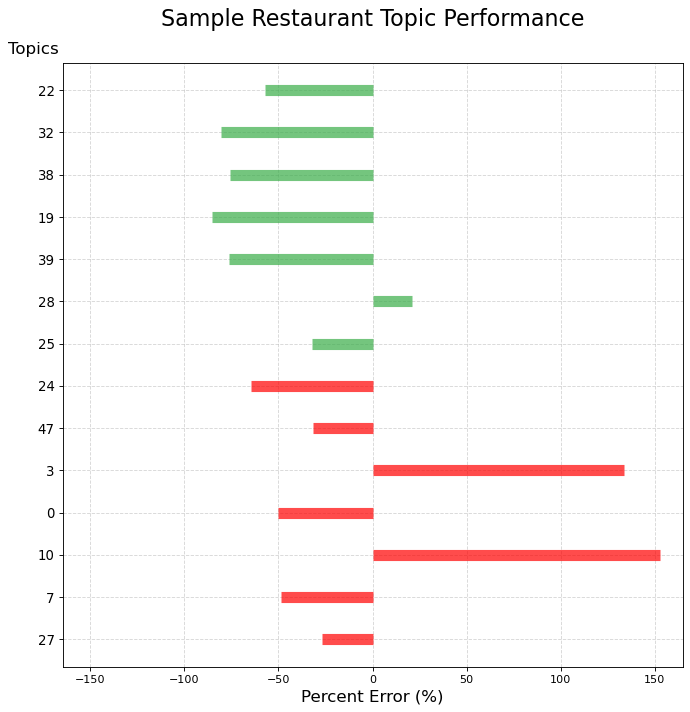

In [53]:
#Plotting feature performance of case example
plt.figure(figsize=(10,10), dpi= 80)
plt.hlines(y = df_case_feats.index, xmin = 0, xmax = df_case_feats['case1'], 
           color=  df_case_feats['Color'], alpha=0.7, linewidth=10)

plt.xlabel(xlabel = 'Percent Error (%)', size = 15)
plt.ylabel(ylabel = 'Topics', size = 15, rotation = 0, y = 1.01)

plt.yticks(df_case_feats.index, df_case_feats['Topic'], fontsize=12)
plt.title('Sample Restaurant Topic Performance', fontsize=20, y = 1.05)
plt.grid(linestyle='--', alpha=0.5)

xabs_max = abs(max(plt.xlim(), key=abs))
plt.xlim(xmin=-xabs_max, xmax=xabs_max)